# Analyse annotation quality

Ready to use notebook to perform: labeling consensus, training data verification and analysis of neural network predictions.

**Input**:
- Existing Project
- List of classes to compare

**Output**:
- New Project in Supervisely with visualized difference

## Configuration

Edit the following settings for your own case

In [1]:
%matplotlib inline

In [2]:
import supervisely_lib as sly
import os
import collections
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

ClassComparison = collections.namedtuple('ClassComparison', 'class1 class2 diff_color')

In [3]:
team_name = "jupyter_tutorials"
workspace_name = "cookbook"
project_name = "tutorial_project_inf"

dst_project_name = "tutorial_project_analysis"

classes_to_compare = [ClassComparison(class1="car", class2="car_dl", diff_color=[255, 0, 0]),
                      ClassComparison(class1="person", class2="person_dl", diff_color=[255, 51, 255])]

# Obtain server address and your api_token from environment variables
# Edit those values if you run this notebook on your own PC
address = os.environ['SERVER_ADDRESS']
token = os.environ['API_TOKEN']

In [4]:
# Initialize API object
api = sly.Api(address, token)

## Verify input values

Test that context (team / workspace / project) exists

In [5]:
# get IDs of team, workspace and project by names

team = api.team.get_info_by_name(team_name)
if team is None:
    raise RuntimeError("Team {!r} not found".format(team_name))

workspace = api.workspace.get_info_by_name(team.id, workspace_name)
if workspace is None:
    raise RuntimeError("Workspace {!r} not found".format(workspace_name))
    
project = api.project.get_info_by_name(workspace.id, project_name)
if project is None:
    raise RuntimeError("Project {!r} not found".format(project_name))
    
print("Team: id={}, name={}".format(team.id, team.name))
print("Workspace: id={}, name={}".format(workspace.id, workspace.name))
print("Project: id={}, name={}".format(project.id, project.name))

Team: id=30, name=jupyter_tutorials
Workspace: id=76, name=cookbook
Project: id=1271, name=tutorial_project_inf


## Get Source Project Meta

In [6]:
meta_json = api.project.get_meta(project.id)
meta = sly.ProjectMeta.from_json(meta_json)
print("Source ProjectMeta: \n", meta)

Source ProjectMeta: 
 ProjectMeta:
Object Classes
+-----------+-----------+----------------+
|    Name   |   Shape   |     Color      |
+-----------+-----------+----------------+
| person_dl |   Bitmap  |  [0, 128, 90]  |
|   car_dl  |   Bitmap  |  [9, 0, 255]   |
|   person  |   Bitmap  |  [0, 255, 18]  |
|    dog    |  Polygon  |  [253, 0, 0]   |
|    car    |  Polygon  | [190, 85, 206] |
|    bike   | Rectangle | [246, 255, 0]  |
+-----------+-----------+----------------+
Image Tags
+-------------+--------------+-----------------------+
|     Name    |  Value type  |    Possible values    |
+-------------+--------------+-----------------------+
| cars_number |  any_number  |          None         |
|     like    |     none     |          None         |
|   situated  | oneof_string | ['inside', 'outside'] |
+-------------+--------------+-----------------------+
Object Tags
+---------------+--------------+-----------------------+
|      Name     |  Value type  |    Possible values    

## Construct Destination ProjectMeta

In [7]:
# prepare new tags for metrics and object classes for difference visualization
comparison_meta_tags = {}
comparison_meta_obj_classes = {}
for cc in classes_to_compare:
    cc_name = '{}_vs_{}'.format(cc.class1, cc.class2)
    comparison_meta_tags[(cc.class1, cc.class2)] = sly.TagMeta('iou_' + cc_name, sly.TagValueType.ANY_NUMBER)
    comparison_meta_obj_classes[(cc.class1, cc.class2)] = sly.ObjClass('diff_' + cc_name, sly.Bitmap, cc.diff_color)

In [8]:
dst_meta = meta.add_img_tag_metas(comparison_meta_tags.values())
dst_meta = dst_meta.add_obj_classes(comparison_meta_obj_classes.values())
print("Destination ProjectMeta:\n", dst_meta)

Destination ProjectMeta:
 ProjectMeta:
Object Classes
+--------------------------+-----------+----------------+
|           Name           |   Shape   |     Color      |
+--------------------------+-----------+----------------+
|        person_dl         |   Bitmap  |  [0, 128, 90]  |
|          car_dl          |   Bitmap  |  [9, 0, 255]   |
|          person          |   Bitmap  |  [0, 255, 18]  |
|           dog            |  Polygon  |  [253, 0, 0]   |
|           car            |  Polygon  | [190, 85, 206] |
|           bike           | Rectangle | [246, 255, 0]  |
|    diff_car_vs_car_dl    |   Bitmap  |  [255, 0, 0]   |
| diff_person_vs_person_dl |   Bitmap  | [255, 51, 255] |
+--------------------------+-----------+----------------+
Image Tags
+-------------------------+--------------+-----------------------+
|           Name          |  Value type  |    Possible values    |
+-------------------------+--------------+-----------------------+
|       cars_number       |  any_numbe

## Create Destination project

In [9]:
# check if destination project already exists. If yes - generate new free name
if api.project.exists(workspace.id, dst_project_name):
    dst_project_name = api.project.get_free_name(workspace.id, dst_project_name)
print("Destination project name: ", dst_project_name)

Destination project name:  tutorial_project_analysis_001


In [10]:
dst_project = api.project.create(workspace.id, dst_project_name)
api.project.update_meta(dst_project.id, dst_meta.to_json())
print("Destination project has been created: id={}, name={!r}".format(dst_project.id, dst_project.name))

Destination project has been created: id=1322, name='tutorial_project_analysis_001'


## Iterate over all images and calculate annotation quality

In [11]:
def _render_labels_for_class_name(labels, class_name, canvas):
    for label in labels:
        if label.obj_class.name == class_name:
            label.geometry.draw(canvas, True)

def safe_ratio(num, denom):
    return (num / denom) if denom != 0 else 0

In [12]:
def process(original_ann, class_comparison):
    ann = original_ann.clone()
    
    # rasterize all objects of class1
    mask_class1 = np.full(ann.img_size, False)
    _render_labels_for_class_name(ann.labels, class_comparison.class1, mask_class1)
    
    # rasterize all objects of class2
    mask_class2 = np.full(ann.img_size, False)
    _render_labels_for_class_name(ann.labels, class_comparison.class2, mask_class2)
    
    # construct intersection and union bitmaps, calculate IoU metric
    intersection = mask_class1 & mask_class2
    union = mask_class1 | mask_class2
    iou = safe_ratio(intersection.sum(), union.sum())
    
    # create and add tag to annotation
    comparison_key = (class_comparison.class1, class_comparison.class2)
    diff_tag = sly.Tag(meta=comparison_meta_tags[comparison_key], value=iou)
    ann = ann.add_tag(diff_tag)
    
    if iou != 0:
        # create and add difference object to annotation
        mask_difference = union ^ intersection
        diff_geometry = sly.Bitmap(data=mask_difference)
        diff_object_class = comparison_meta_obj_classes[comparison_key]
        diff_label = sly.Label(diff_geometry, diff_object_class)
        ann = ann.add_label(diff_label)
    else:
        diff_label = None
    
    return ann, iou, diff_label # iou, diff_label - are used for additional visualization

In [13]:
iou_individual_images = {(cc.class1, cc.class2): [] for cc in classes_to_compare}
all_dst_image_ids = []

for dataset in api.dataset.get_list(project.id):
    print('Dataset: {}'.format(dataset.name), flush=True)
    dst_dataset = api.dataset.create(dst_project.id, dataset.name)
    
    images = api.image.get_list(dataset.id)
    with tqdm(total=len(images), desc="Process annotations") as progress_bar:
        for batch in sly.batched(images):
            image_ids = [image_info.id for image_info in batch]
            image_names = [image_info.name for image_info in batch]
            
            dst_image_infos = api.image.upload_ids(dst_dataset.id, image_names, image_ids)
            dst_image_ids = [image_info.id for image_info in dst_image_infos]
            all_dst_image_ids.extend(dst_image_ids)
            
            ann_infos = api.annotation.download_batch(dataset.id, image_ids)
            anns_to_upload = []
            for ann_info, dst_image_id in zip(ann_infos, dst_image_ids):
                new_ann = sly.Annotation.from_json(ann_info.annotation, meta)
                for cc in classes_to_compare:
                    new_ann, iou, diff_label = process(new_ann, cc)
                    iou_individual_images[(cc.class1, cc.class2)].append(iou)
                anns_to_upload.append(new_ann)
            
            api.annotation.upload_anns(dst_image_ids, anns_to_upload)
            progress_bar.update(len(batch))

Dataset: dataset_02


Process annotations: 100%|██████████| 2/2 [00:00<00:00,  7.87it/s]

Dataset: dataset_01



Process annotations: 100%|██████████| 3/3 [00:00<00:00,  9.07it/s]


## Visualize IoU distribution

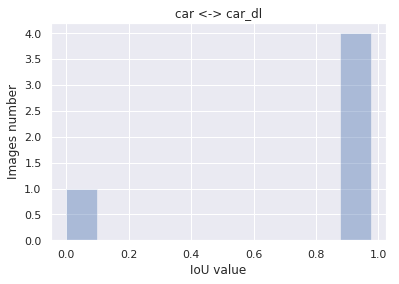

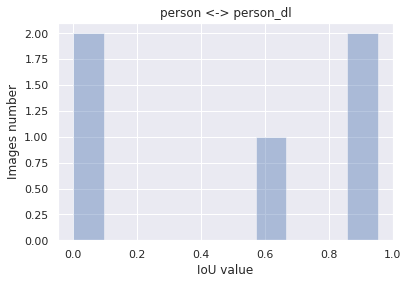

In [14]:
for cc in classes_to_compare:
    fig = plt.figure()
    plt.title('{} <-> {}'.format(cc.class1, cc.class2))
    plt.xlabel("IoU value")
    plt.ylabel("Images number")
    sns.distplot(iou_individual_images[(cc.class1, cc.class2)], bins=10, kde=False)

## Helper function to draw only difference

In [15]:
plt.rcParams["axes.grid"] = False

In [16]:
def _draw_diff(image_id, class_compare):
    diff_object_class = comparison_meta_obj_classes[(class_compare.class1, class_compare.class2)]
    img = api.image.download_np(image_id)
    
    ann_json = api.annotation.download(image_id).annotation
    ann = sly.Annotation.from_json(ann_json, dst_meta)
    
    label_to_draw = [label for label in ann.labels if label.obj_class.name == diff_object_class.name][0]
    label_to_draw.draw(img)
    return img

In [17]:
def draw_min_iou_for_all_pairs():
    for cc in classes_to_compare:
        cc_per_image_ious = iou_individual_images[(cc.class1, cc.class2)]
        nonzero_ious = [iou for iou in cc_per_image_ious if iou > 0]
        nonzero_iou_indices = [idx for idx, iou in enumerate(cc_per_image_ious) if iou > 0]
        max_iou_idx = nonzero_iou_indices[np.argmin(nonzero_ious)]
        iou = cc_per_image_ious[max_iou_idx]
        image_id = all_dst_image_ids[max_iou_idx]

        img = _draw_diff(image_id, cc)
        fig = plt.figure(figsize=(15, 15))
        plt.title('{} <-> {} : {}'.format(cc.class1, cc.class2, iou))
        plt.imshow(img)

## Draw difference with maximum IoU for all class pairs

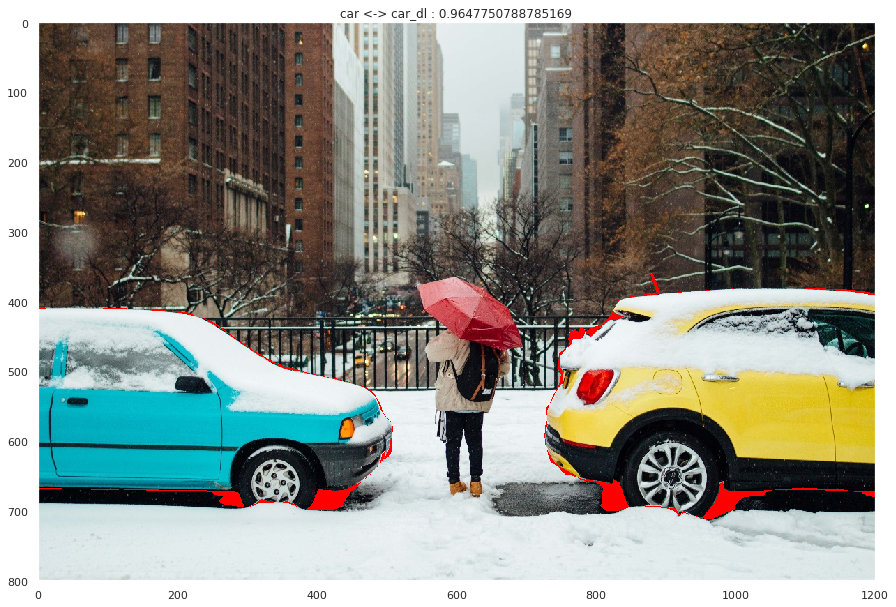

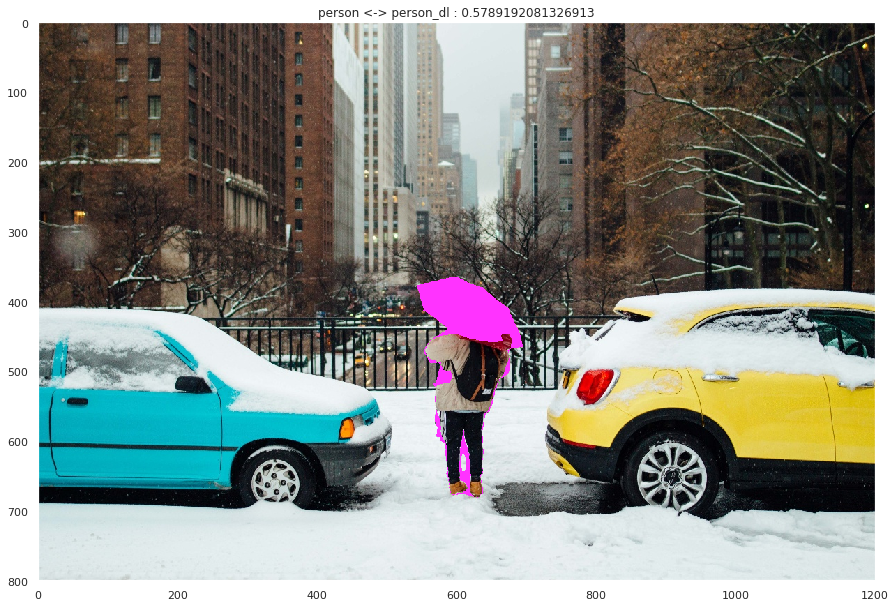

In [18]:
draw_min_iou_for_all_pairs()

# Done!